# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

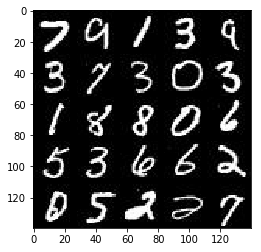

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

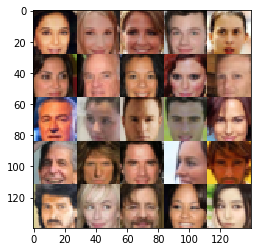

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32,shape=(None,image_width,image_height,image_channels))
    z = tf.placeholder(tf.float32,shape=(None,z_dim))
    lr = tf.placeholder(tf.float32,shape=None)

    return real_input_images, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        alpha = 0.01
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        #print(x1.get_shape())
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        #print(x2.get_shape())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse=not is_train):
        alpha = 0.01
        x1 = tf.layers.dense(z,7*7*128)
        #reshaping to 4d tensor
        x1 = tf.reshape(x1,(-1,7,7,128))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #print(x1.get_shape())
        #? x 7 x 7 x 128
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #print(x2.get_shape())
        #? x 14 x 14 x 256
        
        logits = tf.layers.conv2d_transpose(x2,out_channel_dim,5,strides=2,padding='same')
        #print(logits.get_shape())
        
        out = tf.tanh(logits)
        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    gen_model = generator(input_z,out_channel_dim)
    dis_model_real,dis_logits_real = discriminator(input_real)
    dis_model_fake,dis_logits_fake = discriminator(gen_model,True)
    
    dis_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_real,labels=tf.ones_like(dis_model_real)))
    dis_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake,labels=tf.zeros_like(dis_model_fake)))
    dis_loss = dis_loss_real + dis_loss_fake
        
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake,labels=tf.ones_like(dis_model_fake)))
    
    
    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    model_vars = tf.trainable_variables()
    gen_vars = [v1 for v1 in model_vars if v1.name.startswith('generator')]
    dis_vars = [v1 for v1 in model_vars if v1.name.startswith('discriminator')]

    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    show_every = 50
    print_every = 10
    print(data_shape)
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, len(data_image_mode))
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    step = 0 
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        losses = []
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                #print(batch_images)
                step = step+1
                batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real:batch_images, input_z:batch_z,lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images,lr:learning_rate})

                if step % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if step % show_every == 0:
                    show_generator_output(sess,20,input_z,data_shape[3],data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Epoch 1/2... Discriminator Loss: 0.0043... Generator Loss: 5.5290
Epoch 1/2... Discriminator Loss: 7.8294... Generator Loss: 0.0005
Epoch 1/2... Discriminator Loss: 2.6251... Generator Loss: 19.7091
Epoch 1/2... Discriminator Loss: 0.7793... Generator Loss: 3.7174
Epoch 1/2... Discriminator Loss: 0.4070... Generator Loss: 2.3670


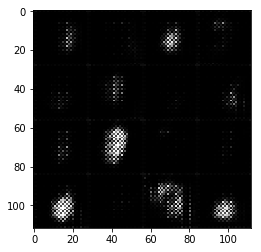

Epoch 1/2... Discriminator Loss: 0.3994... Generator Loss: 2.2037
Epoch 1/2... Discriminator Loss: 2.7768... Generator Loss: 0.1241
Epoch 1/2... Discriminator Loss: 1.7191... Generator Loss: 0.4045
Epoch 1/2... Discriminator Loss: 1.3894... Generator Loss: 1.7719
Epoch 1/2... Discriminator Loss: 1.4800... Generator Loss: 0.4786


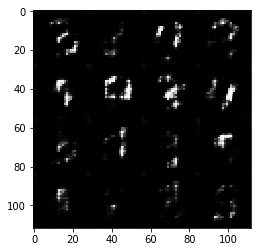

Epoch 1/2... Discriminator Loss: 1.6965... Generator Loss: 0.3106
Epoch 1/2... Discriminator Loss: 1.8915... Generator Loss: 0.2981
Epoch 1/2... Discriminator Loss: 1.2939... Generator Loss: 0.4845
Epoch 1/2... Discriminator Loss: 1.8486... Generator Loss: 3.9380
Epoch 1/2... Discriminator Loss: 2.3227... Generator Loss: 0.1577


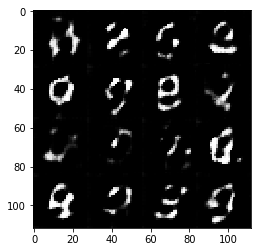

Epoch 1/2... Discriminator Loss: 1.1535... Generator Loss: 0.6237
Epoch 1/2... Discriminator Loss: 1.1409... Generator Loss: 0.8323
Epoch 1/2... Discriminator Loss: 1.1751... Generator Loss: 0.6949
Epoch 1/2... Discriminator Loss: 1.0842... Generator Loss: 1.7486
Epoch 1/2... Discriminator Loss: 1.1011... Generator Loss: 1.1902


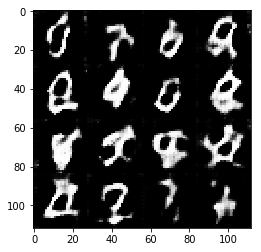

Epoch 1/2... Discriminator Loss: 1.6153... Generator Loss: 0.3490
Epoch 1/2... Discriminator Loss: 0.9798... Generator Loss: 0.7364
Epoch 1/2... Discriminator Loss: 2.3393... Generator Loss: 3.5700
Epoch 1/2... Discriminator Loss: 1.1388... Generator Loss: 2.9000
Epoch 1/2... Discriminator Loss: 1.1946... Generator Loss: 0.5407


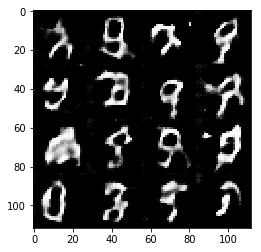

Epoch 1/2... Discriminator Loss: 1.2591... Generator Loss: 5.0206
Epoch 1/2... Discriminator Loss: 1.2058... Generator Loss: 1.4012
Epoch 1/2... Discriminator Loss: 0.5843... Generator Loss: 1.2069
Epoch 1/2... Discriminator Loss: 1.5269... Generator Loss: 0.3692
Epoch 1/2... Discriminator Loss: 1.0600... Generator Loss: 1.0226


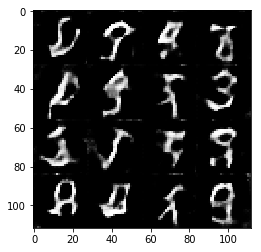

Epoch 1/2... Discriminator Loss: 0.7608... Generator Loss: 1.5541
Epoch 1/2... Discriminator Loss: 1.2695... Generator Loss: 1.5429
Epoch 1/2... Discriminator Loss: 1.0620... Generator Loss: 0.8197
Epoch 1/2... Discriminator Loss: 1.6225... Generator Loss: 0.3163
Epoch 1/2... Discriminator Loss: 1.2144... Generator Loss: 3.9907


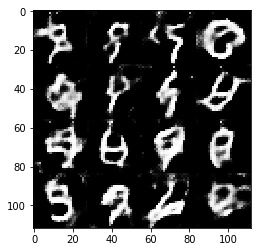

Epoch 1/2... Discriminator Loss: 1.1769... Generator Loss: 0.7412
Epoch 1/2... Discriminator Loss: 0.9036... Generator Loss: 3.1829
Epoch 1/2... Discriminator Loss: 0.9172... Generator Loss: 2.0410
Epoch 1/2... Discriminator Loss: 2.0537... Generator Loss: 0.1876
Epoch 1/2... Discriminator Loss: 1.8282... Generator Loss: 0.2156


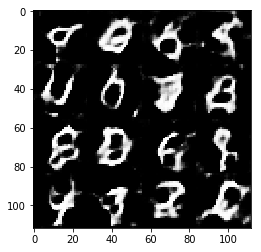

Epoch 1/2... Discriminator Loss: 1.1240... Generator Loss: 2.4892
Epoch 1/2... Discriminator Loss: 2.6265... Generator Loss: 0.1051
Epoch 1/2... Discriminator Loss: 0.9868... Generator Loss: 4.3422
Epoch 1/2... Discriminator Loss: 1.1197... Generator Loss: 3.7687
Epoch 1/2... Discriminator Loss: 1.6287... Generator Loss: 0.3115


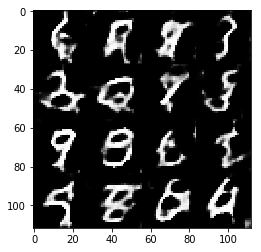

Epoch 1/2... Discriminator Loss: 0.8667... Generator Loss: 2.7998
Epoch 1/2... Discriminator Loss: 0.9167... Generator Loss: 2.9117
Epoch 1/2... Discriminator Loss: 1.5980... Generator Loss: 0.3413
Epoch 1/2... Discriminator Loss: 1.0357... Generator Loss: 2.3319
Epoch 1/2... Discriminator Loss: 0.8193... Generator Loss: 4.3528


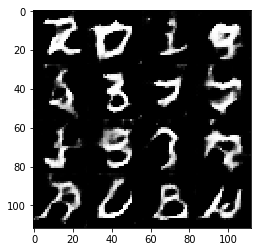

Epoch 1/2... Discriminator Loss: 1.0228... Generator Loss: 1.9666
Epoch 1/2... Discriminator Loss: 1.0572... Generator Loss: 0.8078
Epoch 1/2... Discriminator Loss: 0.6933... Generator Loss: 3.7108
Epoch 1/2... Discriminator Loss: 1.5444... Generator Loss: 0.3511
Epoch 1/2... Discriminator Loss: 0.9090... Generator Loss: 3.9260


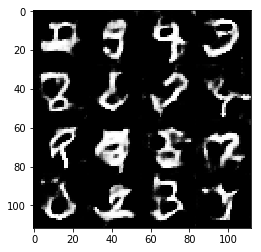

Epoch 1/2... Discriminator Loss: 1.2079... Generator Loss: 2.4446
Epoch 1/2... Discriminator Loss: 0.8116... Generator Loss: 0.9320
Epoch 1/2... Discriminator Loss: 0.8069... Generator Loss: 1.7357
Epoch 1/2... Discriminator Loss: 0.5301... Generator Loss: 1.4951
Epoch 1/2... Discriminator Loss: 0.8348... Generator Loss: 0.8126


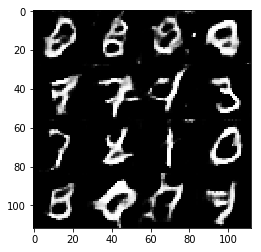

Epoch 1/2... Discriminator Loss: 0.5018... Generator Loss: 3.3114
Epoch 1/2... Discriminator Loss: 0.8128... Generator Loss: 1.9234
Epoch 1/2... Discriminator Loss: 1.1903... Generator Loss: 3.5154
Epoch 1/2... Discriminator Loss: 0.5786... Generator Loss: 3.0880
Epoch 1/2... Discriminator Loss: 0.6703... Generator Loss: 1.0447


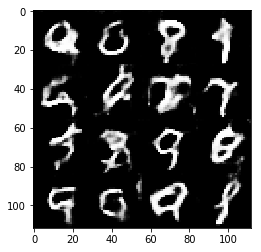

Epoch 1/2... Discriminator Loss: 0.6505... Generator Loss: 4.1433
Epoch 1/2... Discriminator Loss: 1.8820... Generator Loss: 0.2263
Epoch 1/2... Discriminator Loss: 0.7312... Generator Loss: 2.8368
Epoch 1/2... Discriminator Loss: 0.8494... Generator Loss: 1.5102
Epoch 1/2... Discriminator Loss: 0.4392... Generator Loss: 1.5121


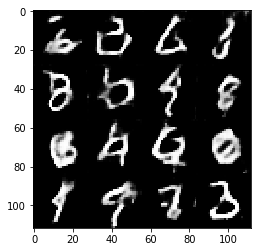

Epoch 1/2... Discriminator Loss: 0.3378... Generator Loss: 2.0371
Epoch 1/2... Discriminator Loss: 1.0803... Generator Loss: 3.1955
Epoch 1/2... Discriminator Loss: 1.2137... Generator Loss: 0.5195
Epoch 1/2... Discriminator Loss: 1.2599... Generator Loss: 0.4426
Epoch 1/2... Discriminator Loss: 0.2555... Generator Loss: 3.7760


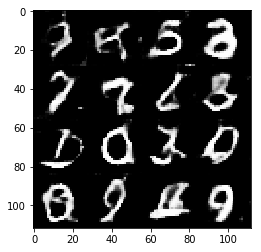

Epoch 1/2... Discriminator Loss: 0.7093... Generator Loss: 3.3084
Epoch 1/2... Discriminator Loss: 0.5355... Generator Loss: 3.3162
Epoch 1/2... Discriminator Loss: 1.3076... Generator Loss: 6.5980
Epoch 1/2... Discriminator Loss: 1.4099... Generator Loss: 0.4112
Epoch 1/2... Discriminator Loss: 0.5674... Generator Loss: 1.7682


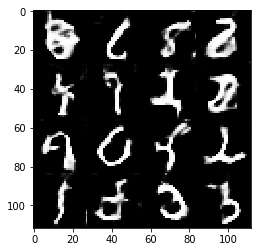

Epoch 1/2... Discriminator Loss: 0.3673... Generator Loss: 3.3692
Epoch 1/2... Discriminator Loss: 2.1877... Generator Loss: 0.1745
Epoch 1/2... Discriminator Loss: 0.5644... Generator Loss: 3.2538
Epoch 1/2... Discriminator Loss: 0.5825... Generator Loss: 1.1502
Epoch 1/2... Discriminator Loss: 1.6058... Generator Loss: 5.9439


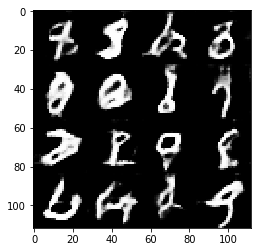

Epoch 1/2... Discriminator Loss: 0.5527... Generator Loss: 2.6512
Epoch 1/2... Discriminator Loss: 1.2740... Generator Loss: 0.4738
Epoch 1/2... Discriminator Loss: 0.4430... Generator Loss: 3.7083
Epoch 1/2... Discriminator Loss: 0.2291... Generator Loss: 2.6979
Epoch 1/2... Discriminator Loss: 0.9626... Generator Loss: 4.1166


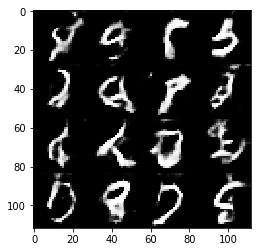

Epoch 1/2... Discriminator Loss: 1.1699... Generator Loss: 2.6091
Epoch 1/2... Discriminator Loss: 1.1016... Generator Loss: 1.6414
Epoch 1/2... Discriminator Loss: 0.6282... Generator Loss: 1.1208
Epoch 2/2... Discriminator Loss: 0.7171... Generator Loss: 0.8535
Epoch 2/2... Discriminator Loss: 0.2948... Generator Loss: 3.3913


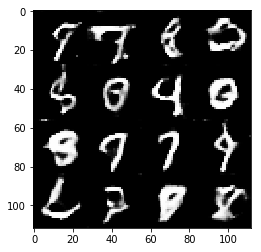

Epoch 2/2... Discriminator Loss: 0.4250... Generator Loss: 1.6106
Epoch 2/2... Discriminator Loss: 0.1672... Generator Loss: 4.4849
Epoch 2/2... Discriminator Loss: 0.3587... Generator Loss: 2.0750
Epoch 2/2... Discriminator Loss: 0.3599... Generator Loss: 1.6469
Epoch 2/2... Discriminator Loss: 0.3743... Generator Loss: 1.9915


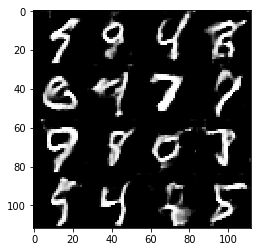

Epoch 2/2... Discriminator Loss: 0.2959... Generator Loss: 2.5531
Epoch 2/2... Discriminator Loss: 0.2556... Generator Loss: 4.3817
Epoch 2/2... Discriminator Loss: 0.5581... Generator Loss: 2.1454
Epoch 2/2... Discriminator Loss: 1.0216... Generator Loss: 1.6593
Epoch 2/2... Discriminator Loss: 0.4323... Generator Loss: 3.4586


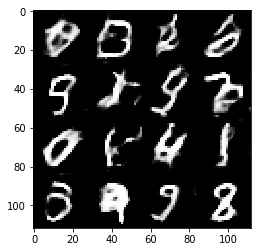

Epoch 2/2... Discriminator Loss: 1.1094... Generator Loss: 0.5802
Epoch 2/2... Discriminator Loss: 0.2754... Generator Loss: 4.1938
Epoch 2/2... Discriminator Loss: 1.8121... Generator Loss: 5.2218
Epoch 2/2... Discriminator Loss: 0.5478... Generator Loss: 1.3092
Epoch 2/2... Discriminator Loss: 1.0024... Generator Loss: 0.7713


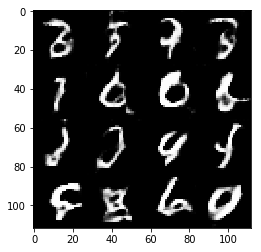

Epoch 2/2... Discriminator Loss: 0.5682... Generator Loss: 4.9248
Epoch 2/2... Discriminator Loss: 0.4090... Generator Loss: 1.6074
Epoch 2/2... Discriminator Loss: 0.1797... Generator Loss: 3.5871
Epoch 2/2... Discriminator Loss: 0.1131... Generator Loss: 3.9487
Epoch 2/2... Discriminator Loss: 0.5411... Generator Loss: 5.1865


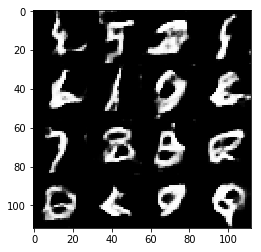

Epoch 2/2... Discriminator Loss: 0.8522... Generator Loss: 0.7757
Epoch 2/2... Discriminator Loss: 0.9465... Generator Loss: 0.7179
Epoch 2/2... Discriminator Loss: 0.3089... Generator Loss: 3.8137
Epoch 2/2... Discriminator Loss: 0.6168... Generator Loss: 2.0453
Epoch 2/2... Discriminator Loss: 0.6468... Generator Loss: 1.2657


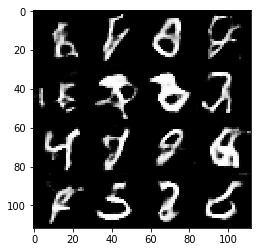

Epoch 2/2... Discriminator Loss: 0.9219... Generator Loss: 1.0390
Epoch 2/2... Discriminator Loss: 2.3616... Generator Loss: 0.1647
Epoch 2/2... Discriminator Loss: 0.4288... Generator Loss: 2.0738
Epoch 2/2... Discriminator Loss: 0.8151... Generator Loss: 6.4667
Epoch 2/2... Discriminator Loss: 0.3397... Generator Loss: 3.8940


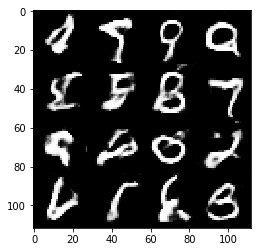

Epoch 2/2... Discriminator Loss: 1.2527... Generator Loss: 0.4506
Epoch 2/2... Discriminator Loss: 1.2325... Generator Loss: 0.5593
Epoch 2/2... Discriminator Loss: 0.3163... Generator Loss: 4.6014
Epoch 2/2... Discriminator Loss: 0.4298... Generator Loss: 3.8109
Epoch 2/2... Discriminator Loss: 0.1646... Generator Loss: 4.6516


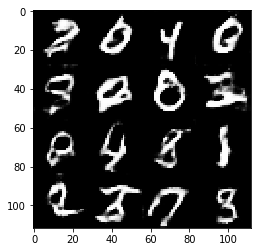

Epoch 2/2... Discriminator Loss: 1.0248... Generator Loss: 0.7623
Epoch 2/2... Discriminator Loss: 0.3609... Generator Loss: 1.6257
Epoch 2/2... Discriminator Loss: 0.3036... Generator Loss: 4.5358
Epoch 2/2... Discriminator Loss: 1.0350... Generator Loss: 6.2990
Epoch 2/2... Discriminator Loss: 0.9037... Generator Loss: 2.1564


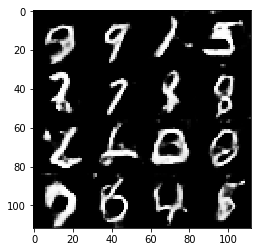

Epoch 2/2... Discriminator Loss: 0.6085... Generator Loss: 2.5237
Epoch 2/2... Discriminator Loss: 1.0310... Generator Loss: 0.7408
Epoch 2/2... Discriminator Loss: 0.3639... Generator Loss: 3.7764
Epoch 2/2... Discriminator Loss: 1.1729... Generator Loss: 3.0714
Epoch 2/2... Discriminator Loss: 0.2639... Generator Loss: 2.6354


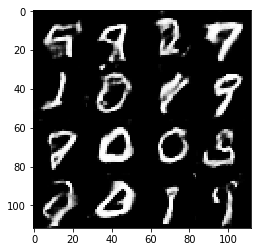

Epoch 2/2... Discriminator Loss: 0.4617... Generator Loss: 2.2813
Epoch 2/2... Discriminator Loss: 0.8611... Generator Loss: 0.8404
Epoch 2/2... Discriminator Loss: 0.6170... Generator Loss: 4.4683
Epoch 2/2... Discriminator Loss: 0.9832... Generator Loss: 6.9437
Epoch 2/2... Discriminator Loss: 0.1540... Generator Loss: 3.6839


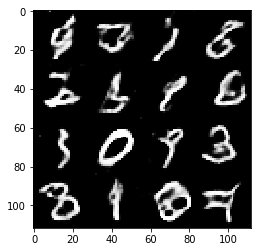

Epoch 2/2... Discriminator Loss: 0.1236... Generator Loss: 3.9807
Epoch 2/2... Discriminator Loss: 0.9321... Generator Loss: 4.6990
Epoch 2/2... Discriminator Loss: 0.1935... Generator Loss: 2.7773
Epoch 2/2... Discriminator Loss: 1.1158... Generator Loss: 1.7479
Epoch 2/2... Discriminator Loss: 0.3057... Generator Loss: 4.4300


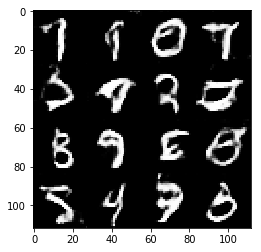

Epoch 2/2... Discriminator Loss: 1.0110... Generator Loss: 0.6697
Epoch 2/2... Discriminator Loss: 1.4015... Generator Loss: 0.4317
Epoch 2/2... Discriminator Loss: 0.7508... Generator Loss: 3.4196
Epoch 2/2... Discriminator Loss: 0.3391... Generator Loss: 1.8996
Epoch 2/2... Discriminator Loss: 0.2754... Generator Loss: 2.3611


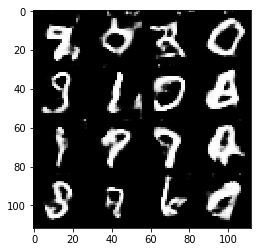

Epoch 2/2... Discriminator Loss: 0.1629... Generator Loss: 4.8549
Epoch 2/2... Discriminator Loss: 0.1151... Generator Loss: 5.9701
Epoch 2/2... Discriminator Loss: 0.6352... Generator Loss: 2.6269
Epoch 2/2... Discriminator Loss: 0.1905... Generator Loss: 4.4367
Epoch 2/2... Discriminator Loss: 0.1880... Generator Loss: 4.9659


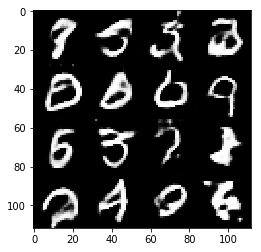

Epoch 2/2... Discriminator Loss: 0.1285... Generator Loss: 3.0276
Epoch 2/2... Discriminator Loss: 0.0752... Generator Loss: 3.8976
Epoch 2/2... Discriminator Loss: 0.3508... Generator Loss: 1.9662
Epoch 2/2... Discriminator Loss: 2.9910... Generator Loss: 5.4895
Epoch 2/2... Discriminator Loss: 0.7981... Generator Loss: 1.6420


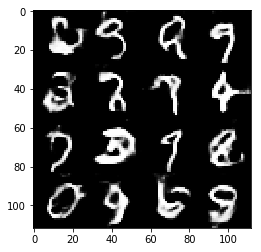

Epoch 2/2... Discriminator Loss: 0.5731... Generator Loss: 2.4520
Epoch 2/2... Discriminator Loss: 0.9164... Generator Loss: 0.8500
Epoch 2/2... Discriminator Loss: 0.8022... Generator Loss: 4.3531
Epoch 2/2... Discriminator Loss: 0.3171... Generator Loss: 2.5892
Epoch 2/2... Discriminator Loss: 0.2847... Generator Loss: 3.1432


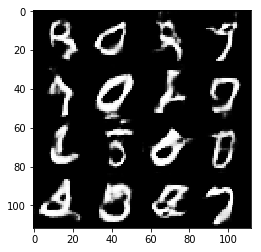

Epoch 2/2... Discriminator Loss: 0.3041... Generator Loss: 2.0980
Epoch 2/2... Discriminator Loss: 0.1093... Generator Loss: 4.0452
Epoch 2/2... Discriminator Loss: 0.5123... Generator Loss: 3.4117
Epoch 2/2... Discriminator Loss: 0.3126... Generator Loss: 3.4227
Epoch 2/2... Discriminator Loss: 0.2692... Generator Loss: 2.3302


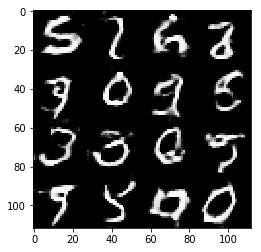

Epoch 2/2... Discriminator Loss: 0.4736... Generator Loss: 5.0058
Epoch 2/2... Discriminator Loss: 0.7799... Generator Loss: 1.0231
Epoch 2/2... Discriminator Loss: 0.2746... Generator Loss: 4.0367
Epoch 2/2... Discriminator Loss: 0.5667... Generator Loss: 1.5174
Epoch 2/2... Discriminator Loss: 1.4667... Generator Loss: 0.4585


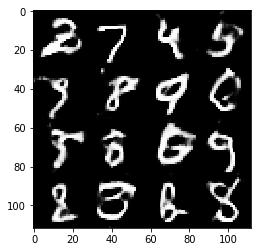

Epoch 2/2... Discriminator Loss: 0.3238... Generator Loss: 2.5130
Epoch 2/2... Discriminator Loss: 1.2993... Generator Loss: 0.4972
Epoch 2/2... Discriminator Loss: 0.9665... Generator Loss: 0.8567
Epoch 2/2... Discriminator Loss: 0.7989... Generator Loss: 1.4896
Epoch 2/2... Discriminator Loss: 0.7306... Generator Loss: 1.6432


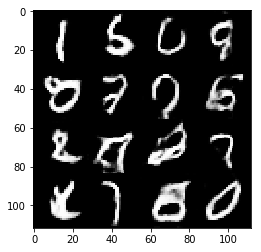

Epoch 2/2... Discriminator Loss: 1.6614... Generator Loss: 0.3416
Epoch 2/2... Discriminator Loss: 0.1600... Generator Loss: 2.7225


In [14]:
batch_size = 64
z_dim = 128
learning_rate = 0.002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
Epoch 1/1... Discriminator Loss: 0.4440... Generator Loss: 1.3316
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.4248
Epoch 1/1... Discriminator Loss: 0.2375... Generator Loss: 14.4436
Epoch 1/1... Discriminator Loss: 4.2366... Generator Loss: 0.0241
Epoch 1/1... Discriminator Loss: 3.3678... Generator Loss: 7.4791


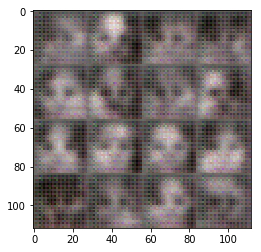

Epoch 1/1... Discriminator Loss: 0.4511... Generator Loss: 1.8623
Epoch 1/1... Discriminator Loss: 0.3525... Generator Loss: 3.7899
Epoch 1/1... Discriminator Loss: 0.1805... Generator Loss: 5.2843
Epoch 1/1... Discriminator Loss: 1.6362... Generator Loss: 0.3202
Epoch 1/1... Discriminator Loss: 0.7859... Generator Loss: 0.8407


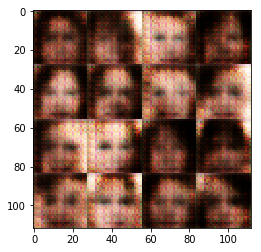

Epoch 1/1... Discriminator Loss: 0.4527... Generator Loss: 1.2705
Epoch 1/1... Discriminator Loss: 0.7186... Generator Loss: 1.0555
Epoch 1/1... Discriminator Loss: 0.9533... Generator Loss: 1.2688
Epoch 1/1... Discriminator Loss: 0.4882... Generator Loss: 4.3877
Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 0.5800


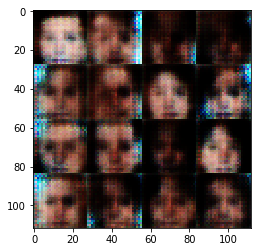

Epoch 1/1... Discriminator Loss: 0.3573... Generator Loss: 2.2646
Epoch 1/1... Discriminator Loss: 1.5259... Generator Loss: 0.5057
Epoch 1/1... Discriminator Loss: 0.7953... Generator Loss: 6.1055
Epoch 1/1... Discriminator Loss: 0.8489... Generator Loss: 3.0666
Epoch 1/1... Discriminator Loss: 0.3725... Generator Loss: 1.8252


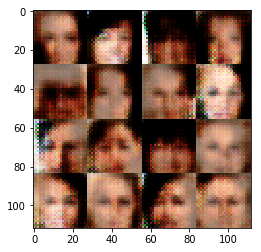

Epoch 1/1... Discriminator Loss: 0.6358... Generator Loss: 1.0617
Epoch 1/1... Discriminator Loss: 0.7762... Generator Loss: 0.9990
Epoch 1/1... Discriminator Loss: 1.1342... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.3855
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 1.7590


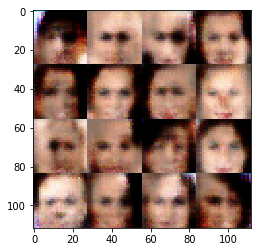

Epoch 1/1... Discriminator Loss: 1.7095... Generator Loss: 0.2764
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.3776
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 1.8283
Epoch 1/1... Discriminator Loss: 1.5837... Generator Loss: 0.3021
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 3.3061


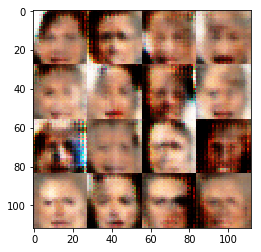

Epoch 1/1... Discriminator Loss: 1.0189... Generator Loss: 0.8336
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 3.8767
Epoch 1/1... Discriminator Loss: 2.2003... Generator Loss: 0.1513
Epoch 1/1... Discriminator Loss: 1.0258... Generator Loss: 1.1376


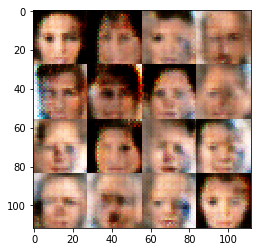

Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 1.4163
Epoch 1/1... Discriminator Loss: 1.8193... Generator Loss: 0.2806
Epoch 1/1... Discriminator Loss: 0.6704... Generator Loss: 1.4923
Epoch 1/1... Discriminator Loss: 1.2268... Generator Loss: 2.2609
Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 0.4970


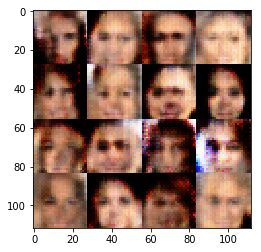

Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 2.2462
Epoch 1/1... Discriminator Loss: 1.7282... Generator Loss: 0.2394
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 1.5536
Epoch 1/1... Discriminator Loss: 1.1096... Generator Loss: 1.0537
Epoch 1/1... Discriminator Loss: 0.9417... Generator Loss: 0.9415


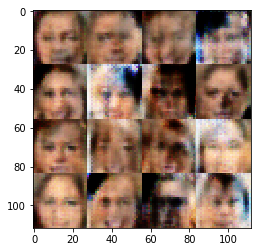

Epoch 1/1... Discriminator Loss: 0.6795... Generator Loss: 2.4824
Epoch 1/1... Discriminator Loss: 1.0187... Generator Loss: 1.1856
Epoch 1/1... Discriminator Loss: 0.6066... Generator Loss: 2.4865
Epoch 1/1... Discriminator Loss: 0.8195... Generator Loss: 1.2058
Epoch 1/1... Discriminator Loss: 1.9975... Generator Loss: 2.6164


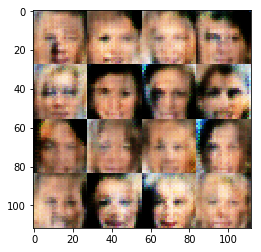

Epoch 1/1... Discriminator Loss: 1.0164... Generator Loss: 0.8777
Epoch 1/1... Discriminator Loss: 1.7521... Generator Loss: 2.6480
Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 4.0658
Epoch 1/1... Discriminator Loss: 1.7118... Generator Loss: 0.2404
Epoch 1/1... Discriminator Loss: 0.7522... Generator Loss: 2.3178


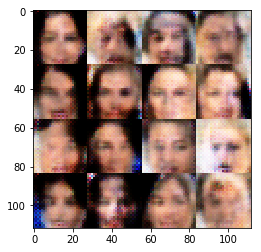

Epoch 1/1... Discriminator Loss: 0.9004... Generator Loss: 1.3500
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 1.8457
Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.5411
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 0.4299
Epoch 1/1... Discriminator Loss: 1.0345... Generator Loss: 1.4906


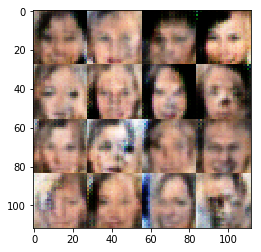

Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.4250
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 0.8711... Generator Loss: 0.9345
Epoch 1/1... Discriminator Loss: 2.1864... Generator Loss: 0.1536
Epoch 1/1... Discriminator Loss: 0.9416... Generator Loss: 0.8263


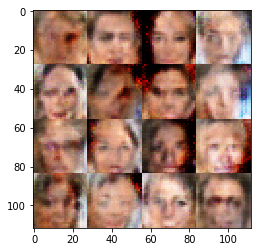

Epoch 1/1... Discriminator Loss: 1.0630... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 1.3238
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 0.8638... Generator Loss: 0.9434
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 1.8961


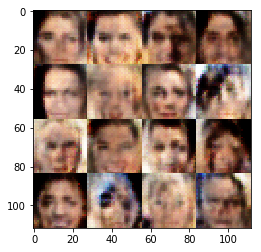

Epoch 1/1... Discriminator Loss: 0.9064... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 1.1984... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.0145... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.0162... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 1.0699


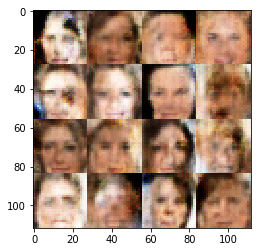

Epoch 1/1... Discriminator Loss: 1.6904... Generator Loss: 1.3289
Epoch 1/1... Discriminator Loss: 1.4660... Generator Loss: 0.3716
Epoch 1/1... Discriminator Loss: 0.9025... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.1894... Generator Loss: 0.9495
Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 1.5360


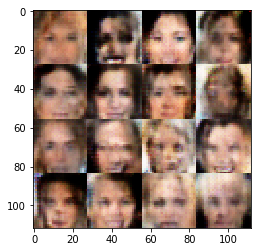

Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 0.8891... Generator Loss: 1.0880
Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 0.8703
Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 1.0871
Epoch 1/1... Discriminator Loss: 1.1020... Generator Loss: 1.2995


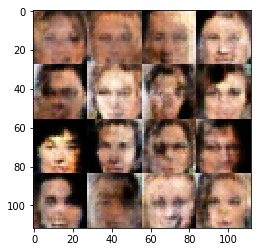

Epoch 1/1... Discriminator Loss: 0.9039... Generator Loss: 0.6967
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.3965
Epoch 1/1... Discriminator Loss: 1.2487... Generator Loss: 0.4741
Epoch 1/1... Discriminator Loss: 0.8300... Generator Loss: 0.9822
Epoch 1/1... Discriminator Loss: 1.0296... Generator Loss: 1.2313


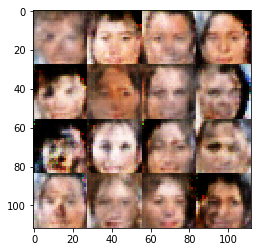

Epoch 1/1... Discriminator Loss: 0.9297... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 1.5331... Generator Loss: 0.3699
Epoch 1/1... Discriminator Loss: 1.0434... Generator Loss: 0.9894
Epoch 1/1... Discriminator Loss: 1.5288... Generator Loss: 0.3992
Epoch 1/1... Discriminator Loss: 1.0373... Generator Loss: 0.6558


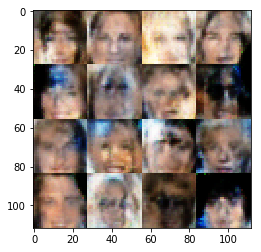

Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 1.2380... Generator Loss: 1.0572
Epoch 1/1... Discriminator Loss: 0.9587... Generator Loss: 1.1233
Epoch 1/1... Discriminator Loss: 1.5013... Generator Loss: 1.0198
Epoch 1/1... Discriminator Loss: 1.0143... Generator Loss: 1.0672


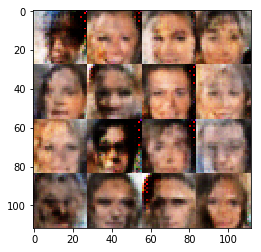

Epoch 1/1... Discriminator Loss: 1.5712... Generator Loss: 0.6022
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.3753
Epoch 1/1... Discriminator Loss: 1.1837... Generator Loss: 1.7534
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 0.5655
Epoch 1/1... Discriminator Loss: 1.6402... Generator Loss: 0.2901


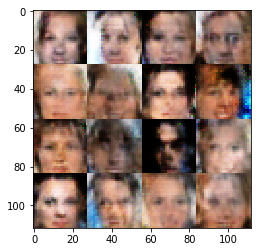

Epoch 1/1... Discriminator Loss: 1.0218... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 1.0630... Generator Loss: 0.9176
Epoch 1/1... Discriminator Loss: 1.6040... Generator Loss: 0.3524
Epoch 1/1... Discriminator Loss: 1.5763... Generator Loss: 0.3410
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.6241


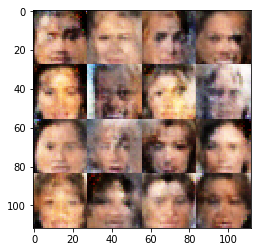

Epoch 1/1... Discriminator Loss: 0.9162... Generator Loss: 0.9193
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.8480
Epoch 1/1... Discriminator Loss: 0.8197... Generator Loss: 0.9793
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.9632
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.6476


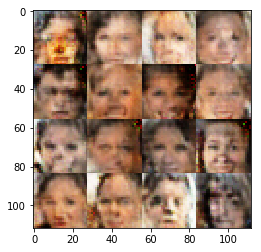

Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 0.9006
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 1.0492
Epoch 1/1... Discriminator Loss: 3.1415... Generator Loss: 2.3035
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.7985


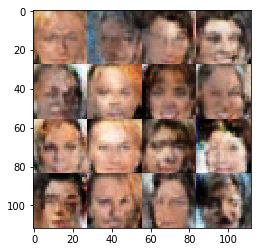

Epoch 1/1... Discriminator Loss: 0.8950... Generator Loss: 2.1726
Epoch 1/1... Discriminator Loss: 0.9417... Generator Loss: 1.2292
Epoch 1/1... Discriminator Loss: 0.9811... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 0.8846... Generator Loss: 1.0939
Epoch 1/1... Discriminator Loss: 1.8345... Generator Loss: 1.1908


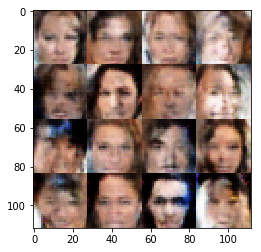

Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 0.5707
Epoch 1/1... Discriminator Loss: 1.9965... Generator Loss: 0.1979
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.5190
Epoch 1/1... Discriminator Loss: 1.5299... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.5251


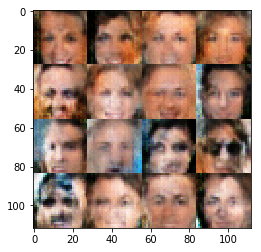

Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.5832
Epoch 1/1... Discriminator Loss: 0.9095... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 0.3980
Epoch 1/1... Discriminator Loss: 0.9342... Generator Loss: 1.1696
Epoch 1/1... Discriminator Loss: 1.4773... Generator Loss: 0.4089


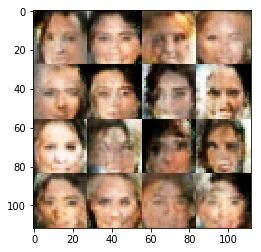

Epoch 1/1... Discriminator Loss: 1.0721... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.5301
Epoch 1/1... Discriminator Loss: 1.0165... Generator Loss: 0.8225
Epoch 1/1... Discriminator Loss: 0.8460... Generator Loss: 1.0090
Epoch 1/1... Discriminator Loss: 0.9938... Generator Loss: 1.2300


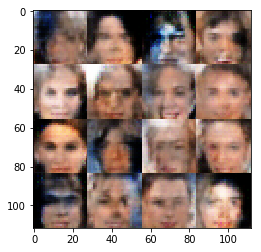

Epoch 1/1... Discriminator Loss: 1.7304... Generator Loss: 0.2606
Epoch 1/1... Discriminator Loss: 1.2327... Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 1.0648... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.8552... Generator Loss: 0.4022
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 0.9728


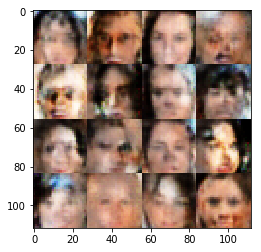

Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.4609
Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.1018... Generator Loss: 1.4887
Epoch 1/1... Discriminator Loss: 2.1464... Generator Loss: 0.1560


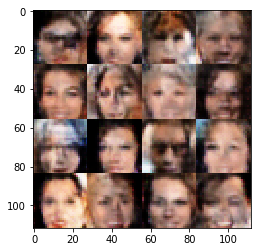

Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.4673
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.5667
Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.5011
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.5411


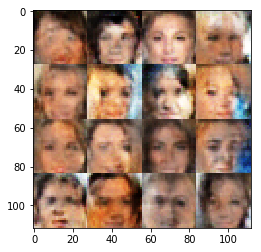

Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.5510
Epoch 1/1... Discriminator Loss: 0.7756... Generator Loss: 1.9704
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.5955
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.7237


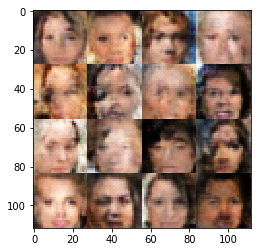

Epoch 1/1... Discriminator Loss: 1.0210... Generator Loss: 1.5820
Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 0.5289
Epoch 1/1... Discriminator Loss: 1.0186... Generator Loss: 0.8913
Epoch 1/1... Discriminator Loss: 1.6024... Generator Loss: 0.2857
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.7463


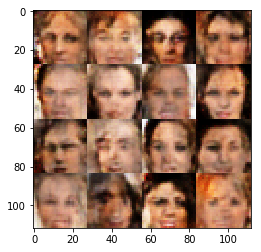

Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.5027
Epoch 1/1... Discriminator Loss: 1.5778... Generator Loss: 0.4087
Epoch 1/1... Discriminator Loss: 1.0932... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.8166... Generator Loss: 0.2677
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.5568


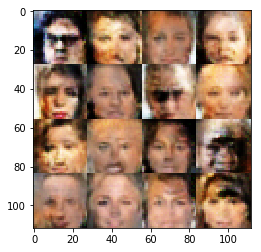

Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.5494
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.6041
Epoch 1/1... Discriminator Loss: 1.0476... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.4338


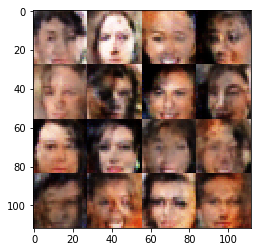

Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.5381
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.4531
Epoch 1/1... Discriminator Loss: 1.5469... Generator Loss: 0.4393
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.5181
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.6523


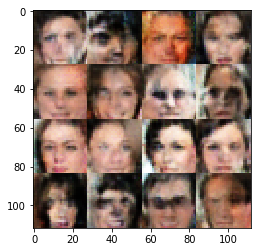

Epoch 1/1... Discriminator Loss: 1.4931... Generator Loss: 0.4286
Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 2.4667
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 0.5699
Epoch 1/1... Discriminator Loss: 1.1250... Generator Loss: 0.6709


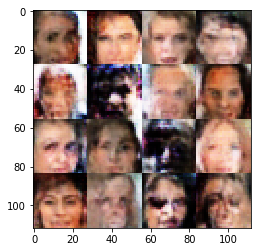

Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 1.3404
Epoch 1/1... Discriminator Loss: 0.9875... Generator Loss: 3.6727
Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.4204
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.5544... Generator Loss: 0.4755


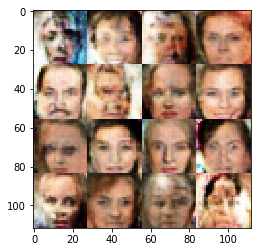

Epoch 1/1... Discriminator Loss: 0.7641... Generator Loss: 1.3020
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.5438
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.5963... Generator Loss: 0.2952
Epoch 1/1... Discriminator Loss: 1.2260... Generator Loss: 0.6500


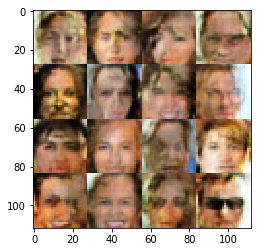

Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.5350
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.5425
Epoch 1/1... Discriminator Loss: 1.1297... Generator Loss: 0.6791


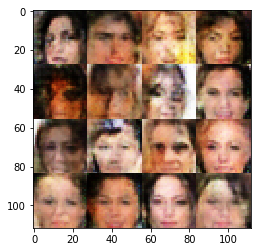

Epoch 1/1... Discriminator Loss: 0.7107... Generator Loss: 1.4675
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 0.6966... Generator Loss: 1.1922
Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 0.4610


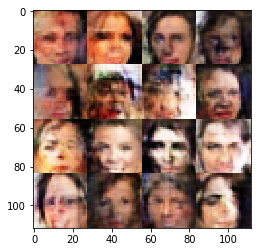

Epoch 1/1... Discriminator Loss: 1.5630... Generator Loss: 0.4709
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 1.0548
Epoch 1/1... Discriminator Loss: 1.9795... Generator Loss: 0.2469
Epoch 1/1... Discriminator Loss: 1.6100... Generator Loss: 0.3520
Epoch 1/1... Discriminator Loss: 1.9004... Generator Loss: 0.2378


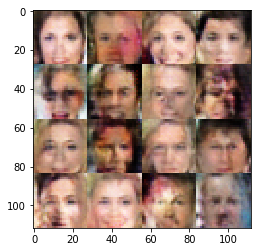

Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.6360
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.5029
Epoch 1/1... Discriminator Loss: 1.5762... Generator Loss: 0.3974
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.5252... Generator Loss: 0.4598


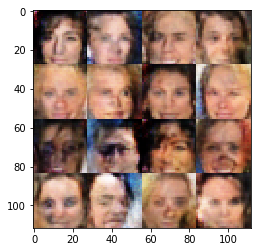

Epoch 1/1... Discriminator Loss: 3.0768... Generator Loss: 0.0915
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.5380
Epoch 1/1... Discriminator Loss: 1.5401... Generator Loss: 0.4084
Epoch 1/1... Discriminator Loss: 1.4972... Generator Loss: 0.5196
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.4921


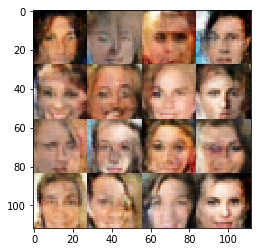

Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.5661
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 1.0118
Epoch 1/1... Discriminator Loss: 1.2341... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.3406


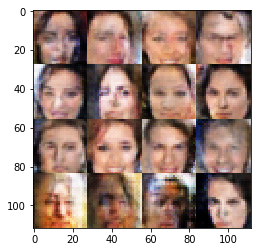

Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.7180... Generator Loss: 0.2759
Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.6431
Epoch 1/1... Discriminator Loss: 1.5361... Generator Loss: 0.5456


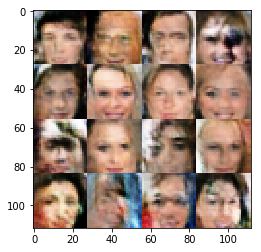

Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.7629
Epoch 1/1... Discriminator Loss: 1.6530... Generator Loss: 0.3875
Epoch 1/1... Discriminator Loss: 1.5817... Generator Loss: 0.4988
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.6048
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.5943


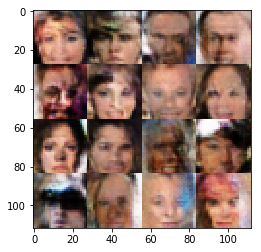

Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.5499
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.5314
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.5966
Epoch 1/1... Discriminator Loss: 2.4473... Generator Loss: 1.4923


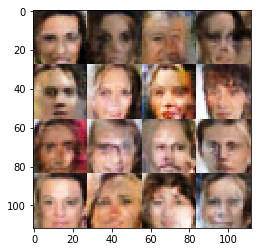

Epoch 1/1... Discriminator Loss: 1.4903... Generator Loss: 0.5897
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.5522
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.4455
Epoch 1/1... Discriminator Loss: 1.5497... Generator Loss: 0.3494


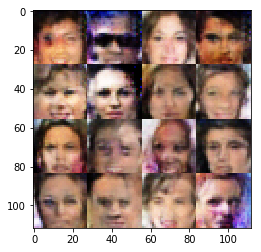

Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.5382
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.5467
Epoch 1/1... Discriminator Loss: 1.1879... Generator Loss: 0.8939
Epoch 1/1... Discriminator Loss: 1.4815... Generator Loss: 0.4065
Epoch 1/1... Discriminator Loss: 1.5893... Generator Loss: 0.3137


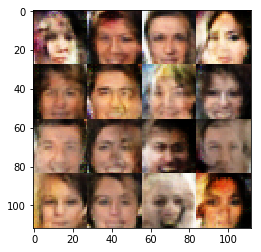

Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.5727
Epoch 1/1... Discriminator Loss: 1.5491... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.5453
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 0.5560
Epoch 1/1... Discriminator Loss: 1.5902... Generator Loss: 0.4753


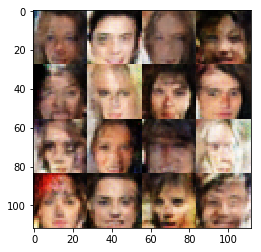

Epoch 1/1... Discriminator Loss: 1.7392... Generator Loss: 1.1657
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.5312
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.4578
Epoch 1/1... Discriminator Loss: 1.9904... Generator Loss: 0.2091
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 0.6196


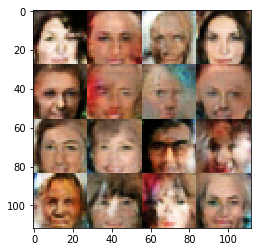

Epoch 1/1... Discriminator Loss: 1.5792... Generator Loss: 0.4342
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.4849
Epoch 1/1... Discriminator Loss: 1.8637... Generator Loss: 0.2642
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.5337
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.5156


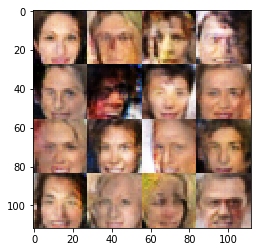

Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.3968
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.5219... Generator Loss: 0.5578
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.5156


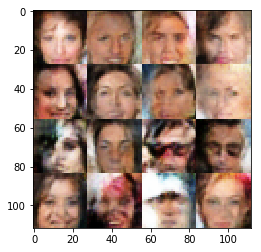

Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.4810
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 1.0726
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.5521
Epoch 1/1... Discriminator Loss: 1.5559... Generator Loss: 0.3474


In [ ]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.